# **Projeto Final - Melanoma classification**

Alexandre Negretti 233609

Bruno Moreira 165295

Guilherme Pereira Corrêa 198397

Renata Biaggi 147807
 


### Link para o vídeo: https://youtu.be/CKrB80vVMb4

### Divisão de tarefas
- Coleta de dados e análise exploratória: Alexandre
- Tratamento dos dados e amostragem: Guilherme
- Modelagem e discussões: Renata, Alexandre, Bruno, Guilherme
- Vídeo: Bruno

## O problema de classificação de melanoma

O câncer é uma doença causada pela reprodução desordenada de células que sofreram algumas
mutações genéticas e adquiriram a capacidade de se reproduzirem independentemente da sinalização
bioquímica do corpo. Este descontrole da reprodução celular desregula o funcionamento saudável do
organismo, invade outros tecidos do corpo (fase conhecida como metástase) podendo levá-lo a óbito.

O câncer de pele é o tipo mais frequente no Brasil (cerca de 30\% das ocorrências) segundo o INCA
(Instituto Nacional do Câncer) justamente porque a população é muito exposta aos raios ultravioletas
que causam as mutações genéticas das células da pele. Dependendo do tipo de célula da pele que sofre
a mutação, o câncer é denominado carcinoma basocelular, carcinoma espinocelular e melanoma.

A figura abaixo ilustra esquematicamente um corte transversal da pele, as três camadas que a compõe
(epiderme, derme e hipoderme) e a ocorrência dos três tipos de câncer de pele.

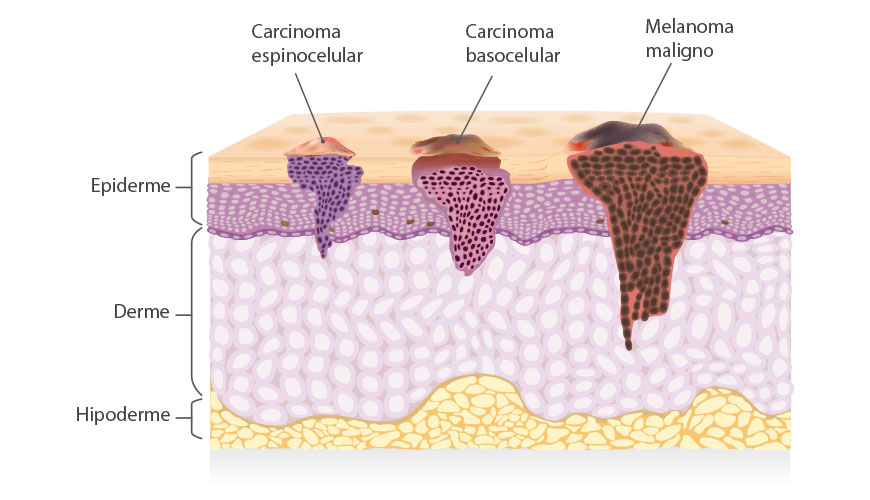

O carcinoma espinocelular afeta células superficiais da epiderme, como visto na figura acima, o carcinoma
basocelular atinge as células profundas da epiderme e o melanoma ocorre nos melanócitos (células
responsáveis pela produção da melanina) que se situam na região basal da epiderme.
Dentre esses tipos, os carcinomas são os mais comuns (cerca de 90% das ocorrências, segundo o INCA) e
os menos agressivos. O melanoma é o mais raro (cerca de 3% das ocorrências), porém é o mais
agressivo, podendo rapidamente provocar metástase no organismo.
O diagnóstico médico de câncer de pele atualmente é feito pelo dermatologista através de um exame
clínico. Para ajudá-lo no diagnóstico, às vezes, faz-se necessário utilizar o dermatoscópio, aparelho que amplia a imagem da lesão em 400 vezes permitindo enxergá-la melhor. Outras vezes, somente é possível o diagnóstico preciso por meio de biópsia e posterior exame histopatológico. 

Dado o problema de identificação visual de uma lesão maligna pelo médico, foi demonstrado na
literatura que o uso de algoritmos de deep learning com uma base de imagens de treino muito grande é
capaz de obter performances visuais no reconhecimento de objetos maiores que a dos próprios seres
humanos [Esteva, A., Kuprel, B., Novoa, R. A., Ko, J., Swetter, S. M., Blau, H. M. & Thrun,S.Dermatologist-
level classification of skin cancer with deep neural networks. Nature,542, 115-118 (2017)].

O presente projeto se insere dentro dessa perspectiva. Utilizamos técnicas de deep learning para tentar identificar a malignidade de certas imagens médicas do conjunto de imagens fornecidas no site do Kaggle. Este notebook encontra-se organizado da seguinte forma: primeiramente, foi feita uma análise exploratória dos dados, o que é imprescindível para a modelagem do sistema de classificação proposto, em seguida foi feito um tratamento das imagens e, por fim, a modelagem da arquitetura utilizada.

In [ ]:
pip install pillow

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from __future__ import print_function

from tqdm import tqdm

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout
from keras import optimizers, regularizers, initializers
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = (15,15) 
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from keras.utils import np_utils

%matplotlib inline

In [ ]:
# Carregando arquivos do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Confirmando arquivos existentes na pasta do Google Drive
import os
os.chdir("/content/drive/Shared drives/Melanoma")
!ls

Amostras						test.csv
Exemplo_Para_Carregar_Lista_Imagem_Desse_Projeto.ipynb	TodasImagens
Graficos						train.csv
Melanoma_Link						train.gsheet
sample_submission.csv


In [ ]:
# Confirmando as imagens existentes na pasta do Google Drive
import os
os.chdir("/content/drive/Shared drives/Melanoma/TodasImagens/jpeg/train/")
!ls

ls: cannot open directory '.': Input/output error


# **Análise exploratória inicial**

Antes de analisar as imagens propriamente, primeiro, vamos verificar os dados que foram fornecidos junto com as imagens das lesões que levam em conta alguns fatores como gênero do paciente, idade e local da lesão. São dois arquivos csv (train e test) contendo essas informações, além das imagens das lesões.

Dividimos o arquivo 'train' em 'maligno' e 'benigno' de acordo com o valor da feature 'target'. Se 'target' é igual a 1, então a lesão é maligna, caso contrário é benigna. 

In [ ]:
test = pd.read_csv('/content/drive/Shared drives/Melanoma/test.csv')   
train = pd.read_csv('/content/drive/Shared drives/Melanoma/train.csv')
train_am = pd.read_csv('/content/drive/Shared drives/Melanoma/train.csv')

In [ ]:
train.head(5)

image_name  patient_id     sex  ...  diagnosis benign_malignant target
0  ISIC_2637011  IP_7279968    male  ...    unknown           benign      0
1  ISIC_0015719  IP_3075186  female  ...    unknown           benign      0
2  ISIC_0052212  IP_2842074  female  ...      nevus           benign      0
3  ISIC_0068279  IP_6890425  female  ...    unknown           benign      0
4  ISIC_0074268  IP_8723313  female  ...    unknown           benign      0

[5 rows x 8 columns]

In [ ]:
train.count()

image_name                       33126
patient_id                       33126
sex                              33061
age_approx                       33058
anatom_site_general_challenge    32599
diagnosis                        33126
benign_malignant                 33126
target                           33126
dtype: int64

In [ ]:
test.count()

image_name                       10982
patient_id                       10982
sex                              10982
age_approx                       10982
anatom_site_general_challenge    10631
dtype: int64

**Eliminando imagens duplicadas nos conjuntos de treino e teste se existirem**

A ideia é verificar se há mais de uma imagem de uma mesma região do corpo do mesmo paciente. Se existir, é necessário excluir antes da análise porque a hipótese é usarmos a maior variedade de imagens possíveis.

Eliminando as imagens duplicadas dos pacientes no conjunto de treino, caso existam.

In [ ]:
train = train.drop_duplicates(subset=['patient_id','anatom_site_general_challenge'], keep='first')
train.count()

image_name                       6360
patient_id                       6360
sex                              6353
age_approx                       6351
anatom_site_general_challenge    6140
diagnosis                        6360
benign_malignant                 6360
target                           6360
dtype: int64

Fazendo o mesmo para o conjunto de teste

In [ ]:
test = test.drop_duplicates(subset=['patient_id','anatom_site_general_challenge'], keep='first')

In [ ]:
test.count()

image_name                       2070
patient_id                       2070
sex                              2070
age_approx                       2070
anatom_site_general_challenge    2009
dtype: int64

# **Estatísticas descritivas**

In [ ]:
regiao = train.groupby('anatom_site_general_challenge')['patient_id'].count()
regiao

anatom_site_general_challenge
head/neck           841
lower extremity    1639
oral/genital         78
palms/soles         197
torso              1955
upper extremity    1430
Name: patient_id, dtype: int64

In [ ]:
total_regiao = 1430 + 1955 + 197 + 78 + 1639 + 841
total_regiao

6140

In [ ]:
def percentual(num):
  per = num/total_regiao
  return per

In [ ]:
regiao_df = pd.DataFrame({'Local':regiao.index, 'Ocorrências':regiao.values}) #Transforma a série acima em dataframe
regiao_df

Local  Ocorrências
0        head/neck          841
1  lower extremity         1639
2     oral/genital           78
3      palms/soles          197
4            torso         1955
5  upper extremity         1430

In [ ]:
regiao_df['% do total'] = regiao_df['Ocorrências'].apply(percentual)
regiao_df

Local  Ocorrências  % do total
0        head/neck          841    0.136971
1  lower extremity         1639    0.266938
2     oral/genital           78    0.012704
3      palms/soles          197    0.032085
4            torso         1955    0.318404
5  upper extremity         1430    0.232899

In [ ]:
test.groupby('anatom_site_general_challenge')['patient_id'].count()

anatom_site_general_challenge
head/neck          268
lower extremity    535
oral/genital        23
palms/soles         48
torso              659
upper extremity    476
Name: patient_id, dtype: int64

# **Maligno**

In [ ]:
maligno = train[(train['target'] == 1)]

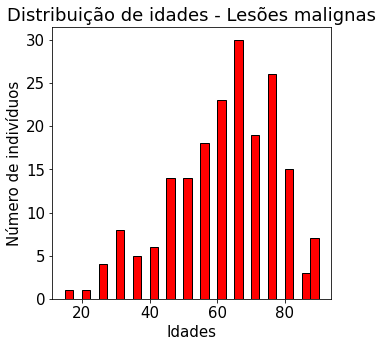

In [ ]:
plt.rcParams['figure.figsize']=(5,5)
plt.rcParams['font.size'] = 15.0
maligno['age_approx'].plot.hist(bins=30,color='r',edgecolor='k')
plt.xlabel('Idades')
plt.ylabel('Número de indivíduos')
plt.title('Distribuição de idades - Lesões malignas')
plt.show()


**Modelo Stacked Column Chart - estudos por ferramenta PowerBI**

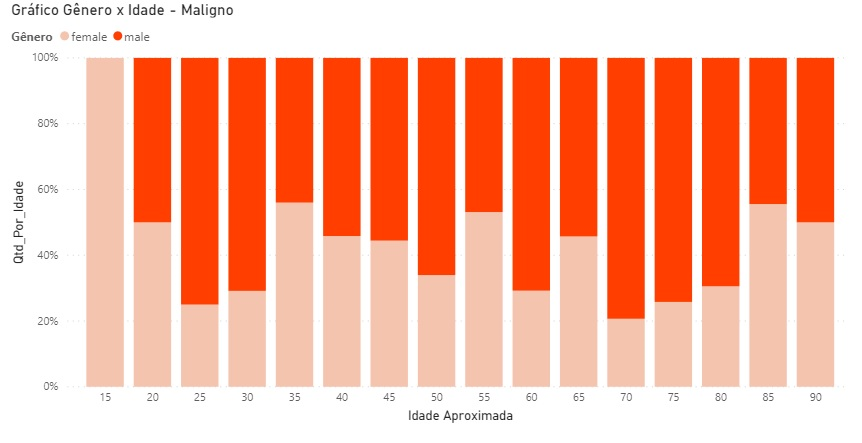

Observando os gráficos acima podemos notar que temos maior incidência de casos malignos na faixa de 50 a 80 anos, em relação ao gênero nos chama atenção haver uma predominância masculina nas idades de 25 e 70 anos.

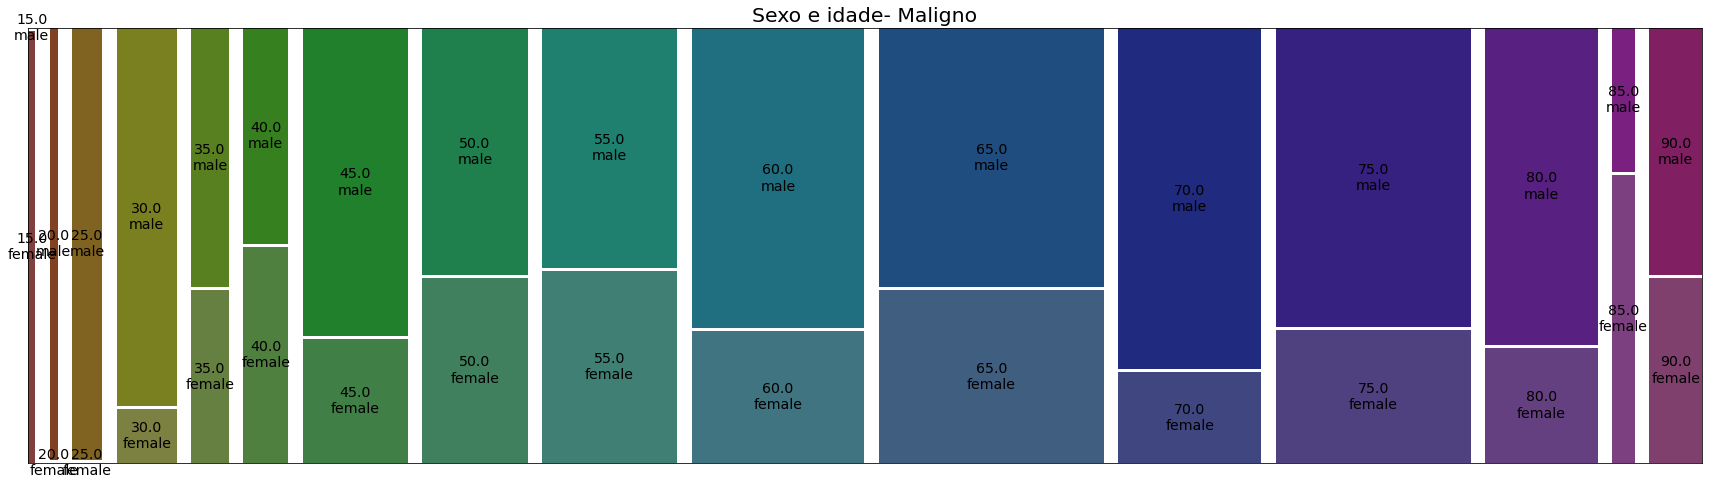

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 17.0
plt.rcParams['figure.figsize']=(30,8)
maligno = maligno.sort_values(by=['age_approx'])
mosaic(maligno, ['age_approx','sex'], gap=0.01, title='Sexo e idade- Maligno', axes_label=False);

# **Análise das regiões onde aparecem as lesões malignas** 

In [ ]:
maligno['anatom_site_general_challenge'].unique()

array(['head/neck', 'torso', 'upper extremity', 'lower extremity',
       'oral/genital', 'palms/soles', nan], dtype=object)

In [ ]:
maligno_local = maligno.groupby('anatom_site_general_challenge')['patient_id'].count()
maligno_local

anatom_site_general_challenge
head/neck          42
lower extremity    37
oral/genital        2
palms/soles         3
torso              58
upper extremity    48
Name: patient_id, dtype: int64

In [ ]:
total = 42 + 37 + 2 + 3 + 58 + 48
total

190

In [ ]:
maligno_local_df = pd.DataFrame({'Local':maligno_local.index, 'Ocorrências':maligno_local.values}) #Transforma a série acima em dataframe
maligno_local_df

Local  Ocorrências
0        head/neck           42
1  lower extremity           37
2     oral/genital            2
3      palms/soles            3
4            torso           58
5  upper extremity           48

In [ ]:
def percentual(num):
  per = num/total
  return per

Percebemos que a maior incidência de lesão maligna é no torso (45%) ou tronco seguido das extremidades do corpo (21% para membros superiores e 19% para membros inferiores).

As regiões menos afetadas são oral/genital e palmas das mãos e pés. A explicação disso está na baixa exposição aos raios solares se comparado aos membros e tronco. 

In [ ]:
maligno_local_df['% do total'] = maligno_local_df['Ocorrências'].apply(percentual)
maligno_local_df

Local  Ocorrências  % do total
0        head/neck           42    0.221053
1  lower extremity           37    0.194737
2     oral/genital            2    0.010526
3      palms/soles            3    0.015789
4            torso           58    0.305263
5  upper extremity           48    0.252632

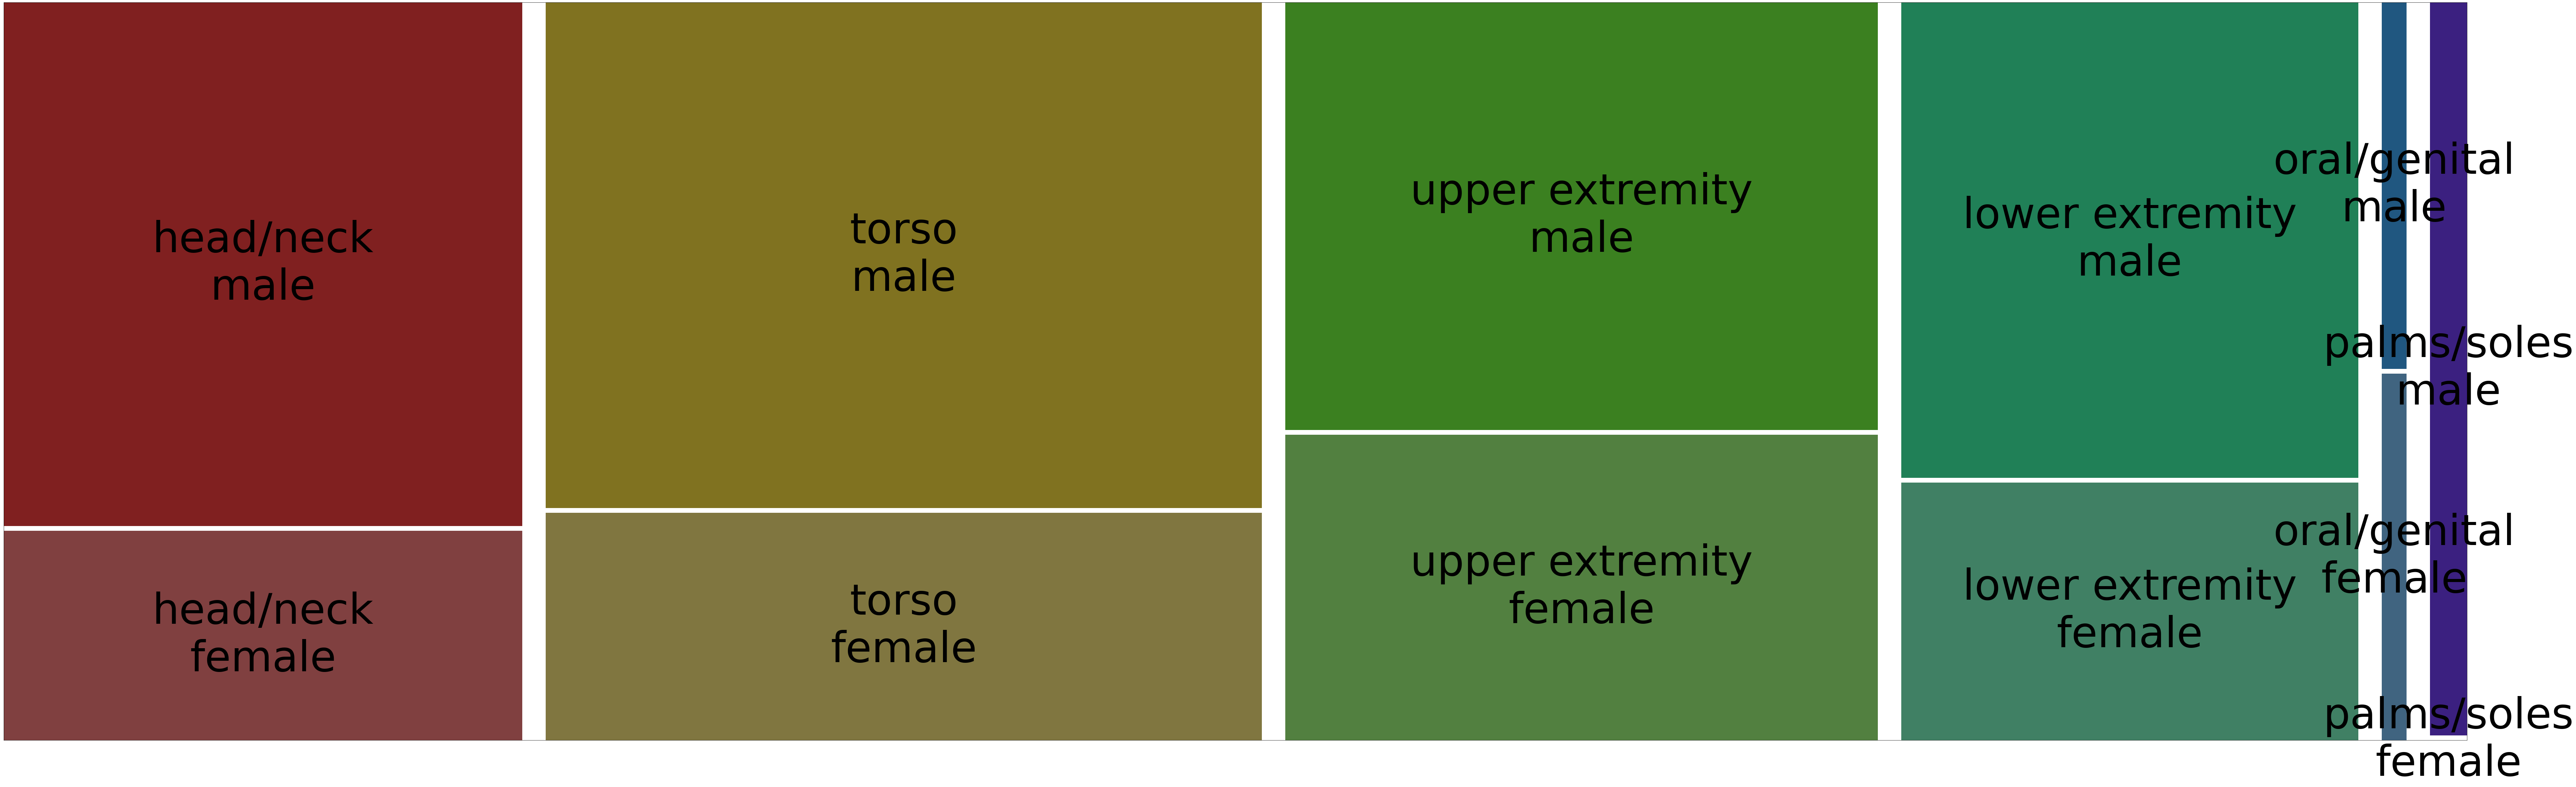

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 150.0
plt.rcParams['figure.figsize']=(130,40)
#mosaic(maligno, ['anatom_site_general_challenge', 'sex'], gap=0.01, title='Sexo e local da lesão - Maligno', axes_label=False);
mosaic(maligno, ['anatom_site_general_challenge', 'sex'], gap=0.01, axes_label=False);

**Segundo modelo de TreeMap- estudos por ferramenta PowerBI**

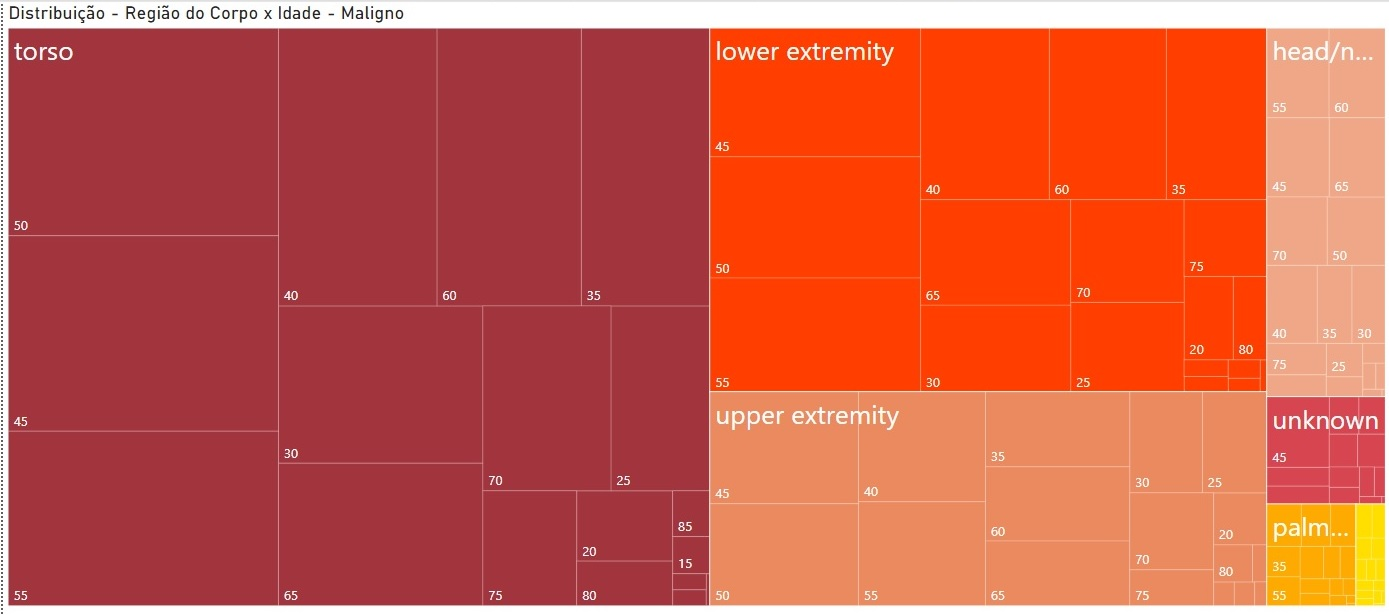

Visualizando o gráfico acima notamos que a maioria das lesões malignas se concentram no “torso”, no tronco do corpo, seguido de baixas extremidades (regiões das pernas, joelhos, tornozelos e pés) e alta extremidades ( regiões do pescoço, ombros , braços e mãos) sendo a faixa de idade de 40 a 50 anos presentes como maioria de casos nessas regiões.

# **Benigno**

In [ ]:
benigno = train[(train['target'] == 0)]

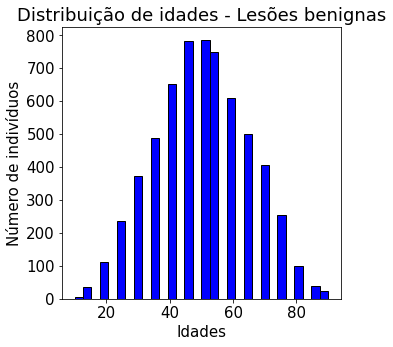

In [ ]:
plt.rcParams['figure.figsize']=(5,5)
plt.rcParams['font.size'] = 15.0
benigno['age_approx'].plot.hist(bins=30,color='b',edgecolor='k')
plt.xlabel('Idades')
plt.ylabel('Número de indivíduos')
plt.title('Distribuição de idades - Lesões benignas')
plt.show()

**Modelo Stacked Column Chart - estudos por ferramenta PowerBI**

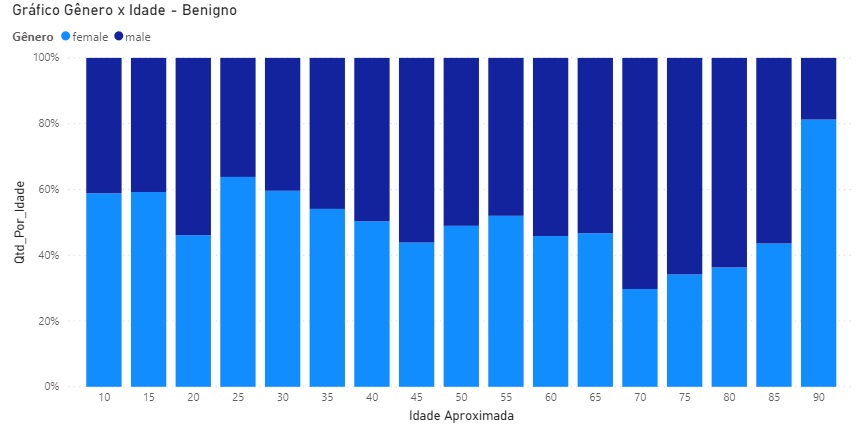

Observando os gráficos acima podemos notar que temos maior incidência de casos benignos na faixa de 40 a 70 anos, em relação ao gênero ao comparar com os casos malignos é perceptível um aumento de casos no gênero feminino e diminuição no masculino

In [ ]:
benigno_local = benigno.groupby('anatom_site_general_challenge')['target'].count()
benigno_local

anatom_site_general_challenge
head/neck           799
lower extremity    1602
oral/genital         76
palms/soles         194
torso              1897
upper extremity    1382
Name: target, dtype: int64

In [ ]:
total2 = 799 + 1602 + 76 + 194 + 1897 + 1382
total2

5950

In [ ]:
def percentual2(num):
  per = num/total2
  return per

In [ ]:
benigno_local_df = pd.DataFrame({'Local':benigno_local.index, 'Ocorrências':benigno_local.values}) #Transforma a série acima em dataframe
benigno_local_df

Local  Ocorrências
0        head/neck          799
1  lower extremity         1602
2     oral/genital           76
3      palms/soles          194
4            torso         1897
5  upper extremity         1382

In [ ]:
benigno_local_df['% do total'] = benigno_local_df['Ocorrências'].apply(percentual2)
benigno_local_df

Local  Ocorrências  % do total
0        head/neck          799    0.134286
1  lower extremity         1602    0.269244
2     oral/genital           76    0.012773
3      palms/soles          194    0.032605
4            torso         1897    0.318824
5  upper extremity         1382    0.232269

**Modelo de TreeMap- estudos por ferramenta PowerBI**

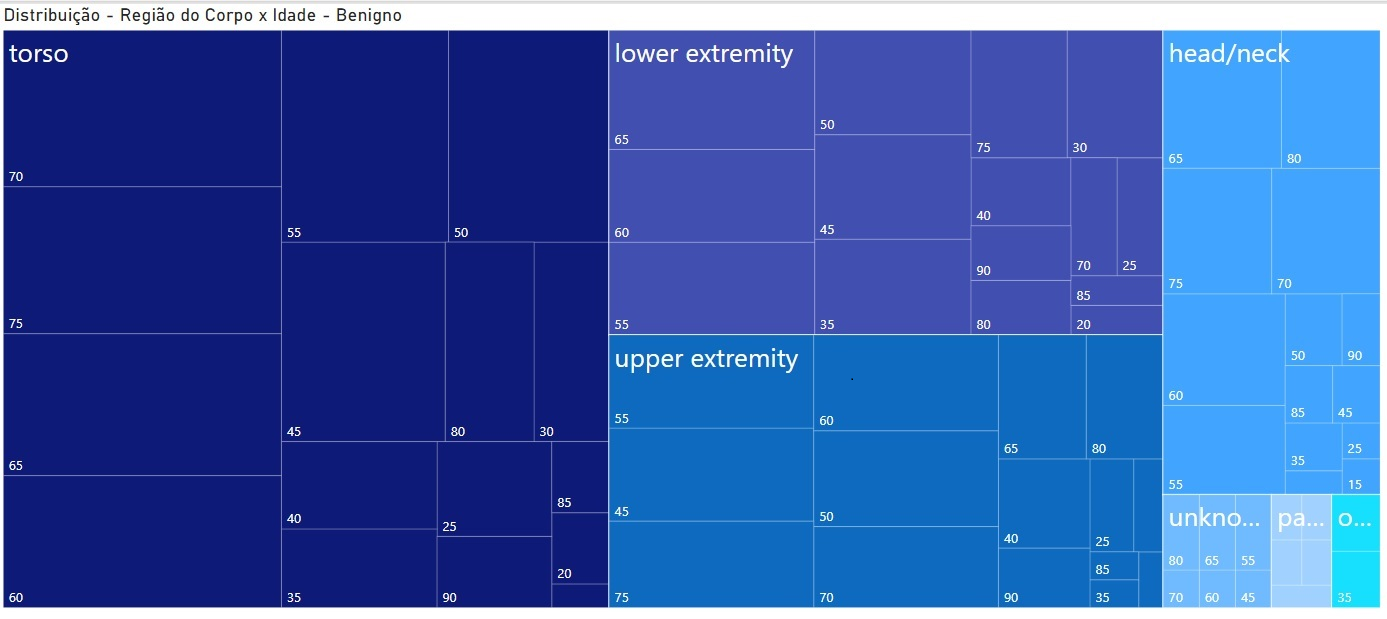

No gráfico acima notamos o mesmo comportamento identificado para lesões malignas, ou seja, as lesões benignas em sua maioria se concentram no tronco do corpo, seguido de baixas extremidades e alta extremidades, porém, a faixa de idade com predominância em comum se concentra entre 60 e 65 anos.

#  **Amostragem**
Notamos que na base de treino havia mais de uma imagem relacionada ao mesmo paciente, em alguns casos referenciando a mesma idade, em outros em idades distintas, optamos por selecionar uma imagem de cada paciente , considerando a imagem em que a maior idade estivesse referenciada, isso fez com que amostra fosse reduzida à 6131 imagens.

Utilizamos o Google Colab com configurações padrão ( Ram de 13,3 GB) como ambiente de desenvolvimento dos modelos e ao tentarmos carregar essas 32.531 imagens de treino, tivemos problemas de limitação física, falta de RAM.

Logo, a fim de mitigar coletamos todas as 179 imagens de maligno existentes e mais 179 imagens de benign para que os dados fiquem balanceados e não tenhamos problemas com memória.

Para as imagens benignas criamos uma feature “chave”, chamada comb_features, com a combinação das features originais: image_name, sex, age_approx, anatom_site_general_challenge, benign_malignant e target. Uma amostra que tivesse as imagens benignas com todas as variações dessas features e na proporção existente entre a quantidade total de imagens benignas considerada em cada caso de amostragem. Por exemplo, se no total tivéssemos 4 imagens na anatomia “torso” e 2 na anatomia “lower extremity” e gerássemos uma amostra de 50%, teríamos como resultado 2 imagens na anatomia “torso” e 1 na anatomia “lower extremity”.

In [ ]:
from sklearn.model_selection import train_test_split

treino=train_am.copy()
# Retirando os valores nulos
treino=treino.dropna()  
# Criando indice de paciente + local da lesao ( um mesmo paciente pode ter lesao em locais diferentes)
treino.insert(0, 'paciente_anatomia',treino['patient_id'].astype(str)+ "_" + treino['anatom_site_general_challenge'].astype(str) )
# Ordenando pacientes pela maior idade
treino.sort_values(by=['age_approx'], inplace=True, ascending=False)
# Retirando pacientes com registros duplicados ( paciente + local da lesao), mantendo apenas os registros de maior idade desse paciente
treino=treino.drop_duplicates(subset='paciente_anatomia', keep='first')
#treino.query('patient_id == "IP_0036322"') #--- exemplo de paciente que mudou de idade
# Separando as amostras de malignos
amostra_malignos= treino[treino['target']==1] #--- total de 179 
# Separando as amostras de benignos
treino_benignos= treino[treino['target']==0] #--- total de 5952
# Criando indice "Chave" ( imagem, sexo, idade, anatomia, benigno/maligno e target) para localizacao de cada registro na base total de treino
treino.insert(0, 'comb_features',treino['image_name'].astype(str)+ "_" + treino['sex'].astype(str)+ "_" + treino['age_approx'].astype(str) + "_" + treino['anatom_site_general_challenge'].astype(str)  + "_" + treino['benign_malignant'].astype(str)  + "_" + treino['target'].astype(str)  ) # criando um indice com as features a serem analisadas
# Criando indice "Chave" ( imagem, sexo, idade, anatomia, benigno/maligno e target) para localizacao de cada registro na base de treinos apenas dos benignos
treino_benignos.insert(0, 'comb_features',treino_benignos['image_name'].astype(str)+ "_" + treino_benignos['sex'].astype(str)+ "_" + treino_benignos['age_approx'].astype(str) + "_" + treino_benignos['anatom_site_general_challenge'].astype(str)  + "_" + treino_benignos['benign_malignant'].astype(str)  + "_" + treino_benignos['target'].astype(str)  ) # criando um indice com as features a serem analisadas

# Retirando a amostra da base de benignos em quantidade aproximada dos malignos para balanceamento
X=treino_benignos['comb_features']
y=treino_benignos['target']



####################################################################################
# Gerando Amostra de Lesoes Benignas
# Gerando uma amostra  de lesoes benignas estratificada proporcional considerando  imagem, sexo, idade, anatomia, benigno/maligno e target
# E quantidade equivalente das lesoes malignas (179)
trainX, amostraX, trainy, amostray = train_test_split(X, y, test_size=0.03, random_state=40, stratify=y)
# summarize
train_0, train_1 = len(trainy[trainy==0]), len(trainy[trainy==1])
amostra_0, amostra_1 = len(amostray[amostray==0]), len(amostray[amostray==1])
print('>Train: 0=%d, 1=%d, Amostra: 0=%d, 1=%d' % (train_0, train_1, amostra_0, amostra_1))

amostra= amostraX.to_frame()

amostra = pd.merge(amostra, treino, how='inner', on=['comb_features'])

amostra_benignos= pd.DataFrame(amostra, columns= ['image_name',	'patient_id',	'sex',	'age_approx',	'anatom_site_general_challenge',	'diagnosis',	'benign_malignant',	'target'])

print('')
print('amostra_benignos - Qtd. distintas de targets       : '  + str(len(amostra_benignos.target.values)))                             # Qtd total de amostragem
print('amostra_benignos - Qtd. distintas de genero        : '  + str(len(set(amostra_benignos.sex.values))))                           # Qtd distinta de genero --->  2 = female/male
print('amostra_benignos - Qtd. distintas de idade         : '  + str(len(set(amostra_benignos.age_approx.values))))                    # Qtd distinta de idade  --->  15
print('amostra_benignos - Qtd. distintas de local anatomia: '  + str(len(set(amostra_benignos.anatom_site_general_challenge.values)))) # Qtd distinta de localizacao da lesao --> 6 head/neck, upper extremity, lower extremity, torso, palms/soles, oral/genital
print('amostra_benignos - Qtd. distintas de Tipo Lesao    : '  + str(len(set(amostra_benignos.benign_malignant.values))))              # Qtd distinta de classificação ---> 2 benign/malignant
print('amostra_benignos - Qtd. distintas de targets       : '  + str(len(set(amostra_benignos.target.values))))                        # Qtd distinta de target  ---> 2 (0/1)
####################################################################################
# Explorando a quantidade da amostra das lesoes malignas

amostra_malignos= pd.DataFrame(amostra_malignos, columns= ['image_name',	'patient_id',	'sex',	'age_approx',	'anatom_site_general_challenge',	'diagnosis',	'benign_malignant',	'target'])
print('')
print('amostra_malignos - Qtd. distintas de targets       : '  + str(len(amostra_malignos.target.values)))                             # Qtd total de amostragem
print('amostra_malignos - Qtd. distintas de genero        : '  + str(len(set(amostra_malignos.sex.values))))                           # Qtd distinta de genero --->  2 = female/male
print('amostra_malignos - Qtd. distintas de idade         : '  + str(len(set(amostra_malignos.age_approx.values))))                    # Qtd distinta de idade  --->  15
print('amostra_malignos - Qtd. distintas de local anatomia: '  + str(len(set(amostra_malignos.anatom_site_general_challenge.values)))) # Qtd distinta de localizacao da lesao --> 6 head/neck, upper extremity, lower extremity, torso, palms/soles, oral/genital
print('amostra_malignos - Qtd. distintas de Tipo Lesao    : '  + str(len(set(amostra_malignos.benign_malignant.values))))              # Qtd distinta de classificação ---> 2 benign/malignant
print('amostra_malignos - Qtd. distintas de targets       : '  + str(len(set(amostra_malignos.target.values))))                        # Qtd distinta de target  ---> 2 (0/1)))   
####################################################################################
# Unificando as amostras de lesoes benignas e malignas em um unico data frame

amostras_unificadas = pd.concat([amostra_benignos, amostra_malignos])

# Explorando a quantidade da amostra das lesoes malignas
print('')
print('amostras_unificadas - Qtd. distintas de targets       : '  + str(len(amostras_unificadas.target.values)))                             # Qtd total de amostragem
print('amostras_unificadas - Qtd. distintas de genero        : '  + str(len(set(amostras_unificadas.sex.values))))                           # Qtd distinta de genero --->  2 = female/male
print('amostras_unificadas - Qtd. distintas de idade         : '  + str(len(set(amostras_unificadas.age_approx.values))))                    # Qtd distinta de idade  --->  15
print('amostras_unificadas - Qtd. distintas de local anatomia: '  + str(len(set(amostras_unificadas.anatom_site_general_challenge.values)))) # Qtd distinta de localizacao da lesao --> 6 head/neck, upper extremity, lower extremity, torso, palms/soles, oral/genital
print('amostras_unificadas - Qtd. distintas de Tipo Lesao    : '  + str(len(set(amostras_unificadas.benign_malignant.values))))              # Qtd distinta de classificação ---> 2 benign/malignant
print('amostras_unificadas - Qtd. distintas de targets       : '  + str(len(set(amostras_unificadas.target.values))))        


>Train: 0=5773, 1=0, Amostra: 0=179, 1=0

amostra_benignos - Qtd. distintas de targets       : 179
amostra_benignos - Qtd. distintas de genero        : 2
amostra_benignos - Qtd. distintas de idade         : 15
amostra_benignos - Qtd. distintas de local anatomia: 6
amostra_benignos - Qtd. distintas de Tipo Lesao    : 1
amostra_benignos - Qtd. distintas de targets       : 1

amostra_malignos - Qtd. distintas de targets       : 179
amostra_malignos - Qtd. distintas de genero        : 2
amostra_malignos - Qtd. distintas de idade         : 14
amostra_malignos - Qtd. distintas de local anatomia: 6
amostra_malignos - Qtd. distintas de Tipo Lesao    : 1
amostra_malignos - Qtd. distintas de targets       : 1

amostras_unificadas - Qtd. distintas de targets       : 358
amostras_unificadas - Qtd. distintas de genero        : 2
amostras_unificadas - Qtd. distintas de idade         : 16
amostras_unificadas - Qtd. distintas de local anatomia: 6
amostras_unificadas - Qtd. distintas de Tipo Lesao    :

In [ ]:
amostras_unificadas.head(5)

image_name  patient_id     sex  ...  diagnosis benign_malignant target
0  ISIC_7055743  IP_5208504  female  ...    unknown           benign      0
1  ISIC_9980854  IP_5350484    male  ...    unknown           benign      0
2  ISIC_2317156  IP_3689742    male  ...    unknown           benign      0
3  ISIC_8441905  IP_5450817    male  ...    unknown           benign      0
4  ISIC_1437817  IP_1512731    male  ...    unknown           benign      0

[5 rows x 8 columns]

In [ ]:
#Retirada a imagem ISIC_0149568, devido ao seu tamanho (1.575)
amostras_unificadas= amostras_unificadas[amostras_unificadas['image_name']!= 'ISIC_0149568'] 

In [ ]:
#Explorando a quantidade da amostra das lesoes 
print('')
print('amostras_unificadas - Qtd. distintas de targets       : '  + str(len(amostras_unificadas.target.values)))                             # Qtd total de amostragem
print('amostras_unificadas - Qtd. distintas de genero        : '  + str(len(set(amostras_unificadas.sex.values))))                           # Qtd distinta de genero --->  2 = female/male
print('amostras_unificadas - Qtd. distintas de idade         : '  + str(len(set(amostras_unificadas.age_approx.values))))                    # Qtd distinta de idade  --->  15
print('amostras_unificadas - Qtd. distintas de local anatomia: '  + str(len(set(amostras_unificadas.anatom_site_general_challenge.values)))) # Qtd distinta de localizacao da lesao --> 6 head/neck, upper extremity, lower extremity, torso, palms/soles, oral/genital
print('amostras_unificadas - Qtd. distintas de Tipo Lesao    : '  + str(len(set(amostras_unificadas.benign_malignant.values))))              # Qtd distinta de classificação ---> 2 benign/malignant
print('amostras_unificadas - Qtd. distintas de targets       : '  + str(len(set(amostras_unificadas.target.values))))        


amostras_unificadas - Qtd. distintas de targets       : 358
amostras_unificadas - Qtd. distintas de genero        : 2
amostras_unificadas - Qtd. distintas de idade         : 16
amostras_unificadas - Qtd. distintas de local anatomia: 6
amostras_unificadas - Qtd. distintas de Tipo Lesao    : 2
amostras_unificadas - Qtd. distintas de targets       : 2


In [ ]:
amostras_unificadas.shape

(358, 8)

In [ ]:
amostras_unificadas.head()

image_name  patient_id     sex  ...  diagnosis benign_malignant target
0  ISIC_7055743  IP_5208504  female  ...    unknown           benign      0
1  ISIC_9980854  IP_5350484    male  ...    unknown           benign      0
2  ISIC_2317156  IP_3689742    male  ...    unknown           benign      0
3  ISIC_8441905  IP_5450817    male  ...    unknown           benign      0
4  ISIC_1437817  IP_1512731    male  ...    unknown           benign      0

[5 rows x 8 columns]

#**Aplicação de alguns Tratamentos de Imagens para auxilio de Processamento**

Imagens com aplicação de cropped ( recorte)  central da imagem por altura e largura



## **Exemplo de imagem bruta de lesão benigna**

Imagem  aleatória da base de amostra de treino original para comparação - Lesão Benigna
  * Imagem 18  ISIC_8319711	
  * IP_2290360/	male / 450	/ lower extremity/ 	nevus	/benign/	0

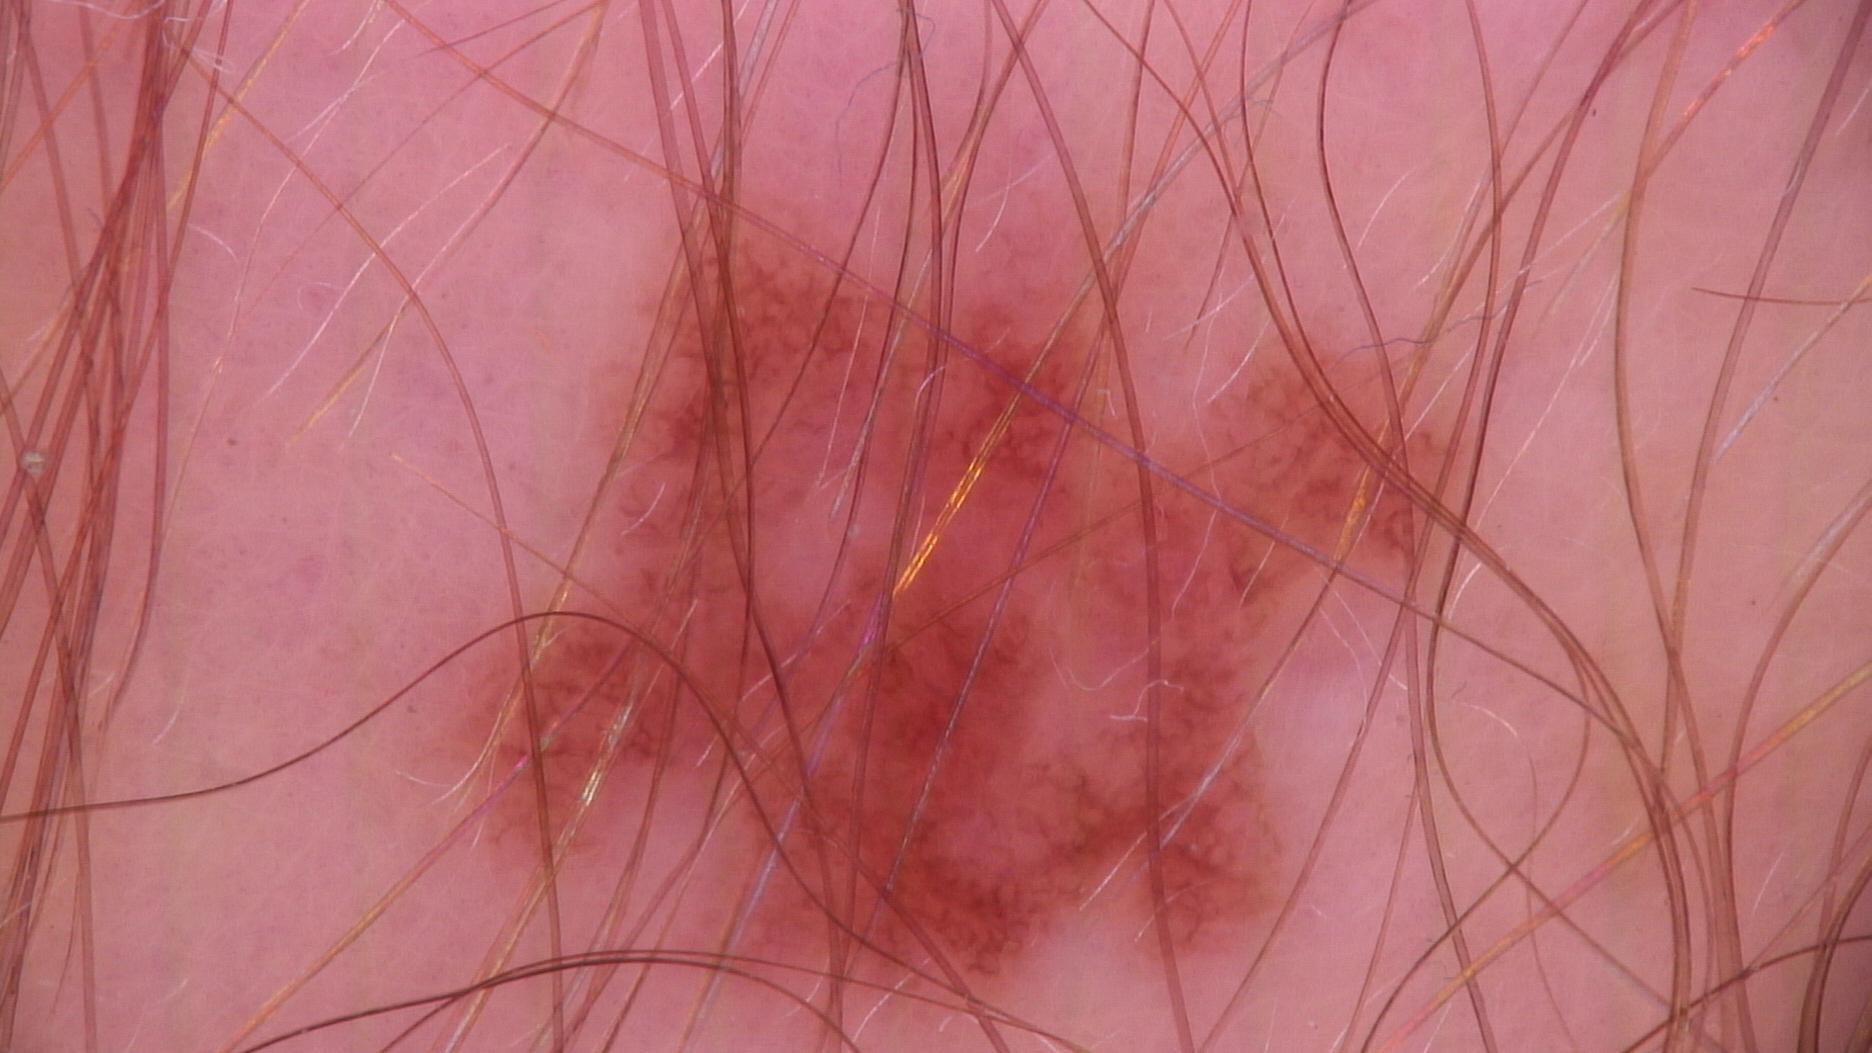

In [ ]:
image.load_img('/content/drive/Shared drives/Melanoma/TodasImagens/jpeg/train/'+amostras_unificadas['image_name'].iloc[18]+'.jpg')

## **Exemplo de imagem bruta de lesão maligna**

Imagem  aleatória da base de amostra de treino original para comparação - Lesão Maligna
  * Imagem 256 - ISIC_2255411 
  * IP_7868912/	male/	65.0	/upper extremity/	melanoma/	malignant/	1

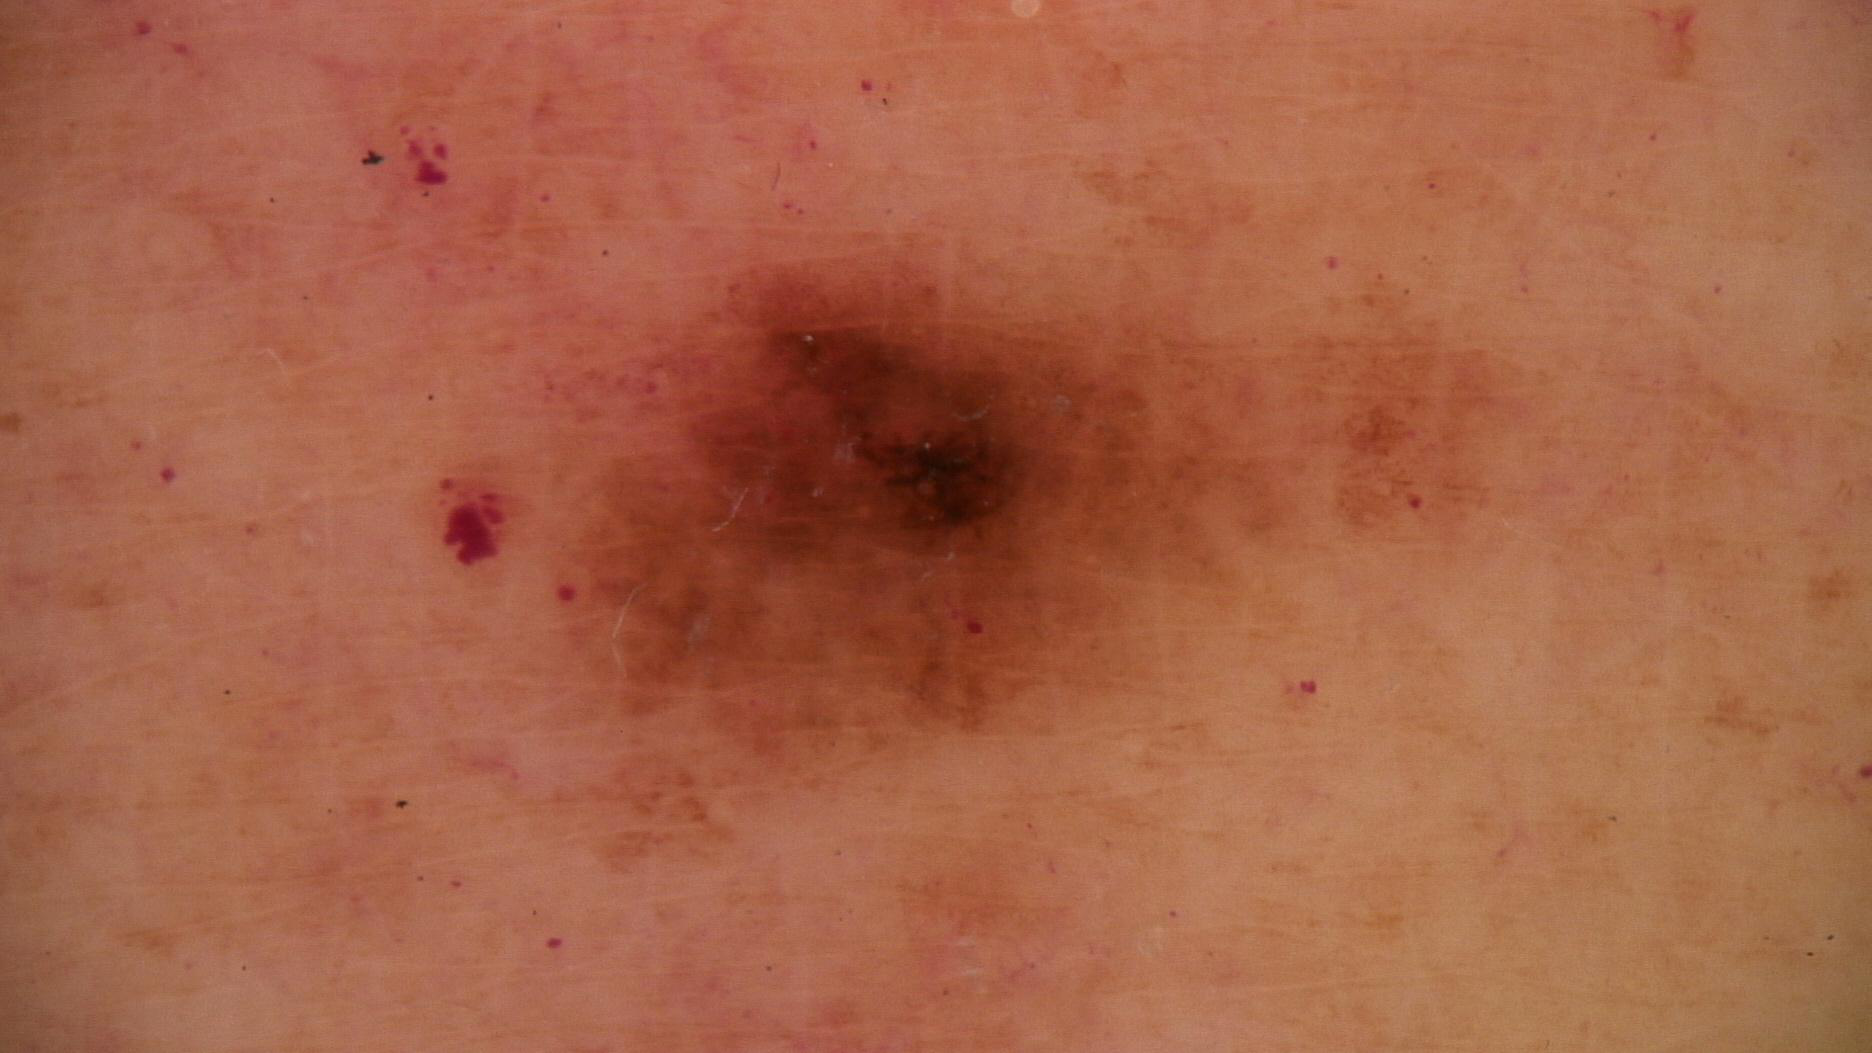

In [ ]:
image.load_img('/content/drive/Shared drives/Melanoma/TodasImagens/jpeg/train/'+amostras_unificadas['image_name'].iloc[256]+'.jpg')

## Tratamento 
Aplicamos as médias entre as diferenças entre tamanho atual e novo tamanho nas dimensões na largura e altura aplicando-as à direita, esquerda , acima e abaixo. Efetuando o comando crop da library PIL para efetuar o recorte da imagem.

In [ ]:
new_width= 400
new_height = 400

train_image = []
for i in tqdm(range(amostras_unificadas.shape[0])):
  #  print(str(i) + " - " + teste['image_name'].iloc[i])
    img = image.load_img('/content/drive/Shared drives/Melanoma/TodasImagens/jpeg/train/'+amostras_unificadas['image_name'].iloc[i]+'.jpg')
    width, height = img.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    img = img.crop((left, top, right, bottom))
    img = image.img_to_array(img) # transforma  o formato de PIL imagem para uma matriz Numpy.
    img = img/255  # imagens coloridas
    train_image.append(img)
X_train = np.array(train_image)
#X_train.astype(np.float32)
X_train.shape

100%|██████████| 358/358 [06:17<00:00,  1.05s/it]


(358, 400, 400, 3)

Visualização de algumas imagens com o **Tratamento**:

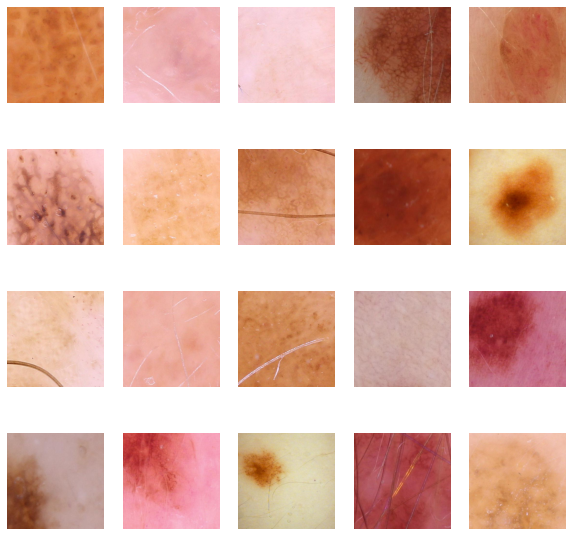

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(4 * 5):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i])
    plt.axis('off')

# **Trabalhando somente com os labels (maligno ou benigno) das imagens**

In [ ]:
y_train = (amostras_unificadas.drop(['image_name', 'patient_id','sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',  ],axis=1))
y_train=np.array(y_train)
y_train.shape

(358, 1)

## **Divisão da amostra_unificada em treino e validação**

Antes de testar os modelos, é necessário dividir a amostra de treino acima em dois conjuntos: treino e validação. 80% dos dados de (X_train, y_train) serão o novo conjunto de treino ( X_train_f, y_train_f)

In [ ]:
X_train_f, X_valid, y_train_f, y_valid = train_test_split(X_train, y_train, random_state=77, test_size=0.20)

In [ ]:
print('amostras em treino: %i' % X_train_f.shape[0],
      'amostras em validação: %i' % X_valid.shape[0],
      'número de características: %i' % X_train_f.shape[1],
      'número de características validação: %i' % X_valid.shape[1],
      'número de classes: %i' % (np.max(y_train_f) + 1),
      sep='\n', end='\n\n')

amostras em treino: 286
amostras em validação: 72
número de características: 400
número de características validação: 400
número de classes: 2



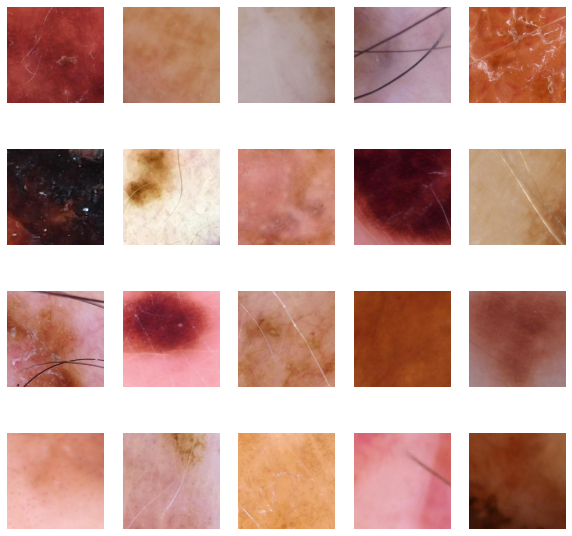

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(4 * 5):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_f[i])
    plt.axis('off')

## **REFERÊNCIAS:**

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

https://keras.io/api/preprocessing/image/


https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/
https://www.it-swarm.dev/pt/python/amostragem-estratificada-em-pandas/832430095/
http://scikit.ml/stratification.html


https://www.netquest.com/blog/br/blog/br/amostragem-probabilistica-amostra-estratificada#:~:text=Wh%20%C3%A9%20o%20peso%20que,esta%20camada%20representa%20na%20popula%C3%A7%C3%A3o


# **Modelagem**

#  **Baseline**

Como o nosso baseline, resolvemos escolher uma arquitetura já implementada e pré-treinada na
 
ImageNet. No site https://keras.io/api/applications/, escolhemos, inicialmente, a ResNet50 para usar seus pesos. A escolha baseou-se na performance desse modelo pré-treinado com os datasets de
validação da Imagenet. Descartamos a saída original e congelamos as camadas. Em seguida, adicionamos uma nova camada de saída com 2 classes.
Nesse experimento, utilizamos um valor de 0.5 para o ‘momentum e as imagens submetidas ao tratamento.



In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
modelo1 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
#modelo1.summary()

In [ ]:
# Congela camadas pré-treinadas
for layer in modelo1.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
baseline = tf.keras.Sequential([
  modelo1,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.5)

baseline.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

## **Experimento 1: Baseline**

In [ ]:
from keras.utils import np_utils

y_train_f = np_utils.to_categorical(y_train_f, 2)
y_valid = np_utils.to_categorical(y_valid, 2)
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_train_f)

In [ ]:
# Número de épocas e o tamanho do batch 
epocas = 100
tam_batch = 32
# Treinamento da rede
resultado = baseline.fit_generator(datagen.flow(X_train_f, y_train_f, batch_size=tam_batch), validation_data=(X_valid, y_valid),steps_per_epoch=len(X_train_f) // tam_batch, epochs=epocas)

Epoch 1/100
8/8 [==============================] - 4s 498ms/step - loss: 0.7161 - accuracy: 0.5078 - val_loss: 0.6952 - val_accuracy: 0.4722
Epoch 2/100
8/8 [==============================] - 3s 407ms/step - loss: 0.7273 - accuracy: 0.4449 - val_loss: 0.6943 - val_accuracy: 0.4722
Epoch 3/100
8/8 [==============================] - 3s 413ms/step - loss: 0.6960 - accuracy: 0.5551 - val_loss: 0.7035 - val_accuracy: 0.5278
Epoch 4/100
8/8 [==============================] - 3s 412ms/step - loss: 0.7137 - accuracy: 0.4843 - val_loss: 0.6938 - val_accuracy: 0.5278
Epoch 5/100
8/8 [==============================] - 3s 409ms/step - loss: 0.7042 - accuracy: 0.4843 - val_loss: 0.6950 - val_accuracy: 0.5278
Epoch 6/100
8/8 [==============================] - 3s 411ms/step - loss: 0.7084 - accuracy: 0.4606 - val_loss: 0.6964 - val_accuracy: 0.5278
Epoch 7/100
8/8 [==============================] - 3s 401ms/step - loss: 0.7215 - accuracy: 0.4961 - val_loss: 0.7035 - val_accuracy: 0.4722
Epoch 8/100
8

### **Avaliação do experimento 1 (baseline)**

In [ ]:
def grafico_loss_epoca(modelo):  
    plt.plot(modelo.history['loss'])
    plt.plot(modelo.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('época')
    plt.legend(['treino', 'validação'], loc='upper left')
    plt.show()

Gráfico loss X época experimento 1 (baseline)

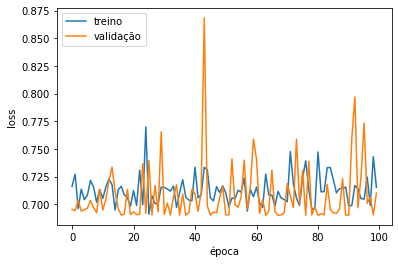

In [ ]:
#Gráfico loss x época do modelo baseline
grafico_loss_epoca(resultado)

AUC do experimento 1 (baseline)

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

# 
preds = baseline.predict(validation_generator)

batch_index = 0
data_list = []
while batch_index <= validation_generator.batch_index:
    _, label = validation_generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

gt = np.argmax(data_list, axis=1)
auc = roc_auc_score(gt, preds[:,1])
print("auc :", auc)

auc : 0.6346749226006192


## **Experimento 2** : VGG16 

Usamos VGG16 com fine-tunning com as imagens do tratamento, camada densa com função de ativação relu e com uma menor taxa de aprendizado (0.0001) e mesmo momentum.

In [ ]:
#Congela camadas pré-treinadas
for layer in modelo2.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
experimento2 = tf.keras.Sequential([
  modelo2,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='relu')
])

experimento2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.5)
experimento2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
from keras.utils import np_utils

y_train_f = np_utils.to_categorical(y_train_f, 2)
y_valid = np_utils.to_categorical(y_valid, 2)
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_train_f)

In [ ]:
# Número de épocas e o tamanho do batch 
epocas = 100
tam_batch = 32
# Treinamento da rede
resultado5 = experimento2.fit_generator(datagen.flow(X_train_f, y_train_f, batch_size=tam_batch), validation_data=(X_valid, y_valid),steps_per_epoch=len(X_train_f) // tam_batch, epochs=epocas)

Epoch 1/100
8/8 [==============================] - 3s 434ms/step - loss: 0.7947 - accuracy: 0.5118 - val_loss: 0.7351 - val_accuracy: 0.4444
Epoch 2/100
8/8 [==============================] - 3s 420ms/step - loss: 0.6983 - accuracy: 0.5039 - val_loss: 0.7145 - val_accuracy: 0.4444
Epoch 3/100
8/8 [==============================] - 3s 419ms/step - loss: 0.6892 - accuracy: 0.5236 - val_loss: 0.7087 - val_accuracy: 0.4444
Epoch 4/100
8/8 [==============================] - 3s 420ms/step - loss: 0.6888 - accuracy: 0.5079 - val_loss: 0.7062 - val_accuracy: 0.4167
Epoch 5/100
8/8 [==============================] - 3s 422ms/step - loss: 0.6866 - accuracy: 0.5551 - val_loss: 0.7044 - val_accuracy: 0.4861
Epoch 6/100
8/8 [==============================] - 3s 426ms/step - loss: 0.6881 - accuracy: 0.5742 - val_loss: 0.7035 - val_accuracy: 0.5139
Epoch 7/100
8/8 [==============================] - 3s 426ms/step - loss: 0.6873 - accuracy: 0.5984 - val_loss: 0.7035 - val_accuracy: 0.5139
Epoch 8/100
8

### **Avaliação do experimento 2**

Gráfico loss X época experimento 2

Mudar a função de ativação da camada densa causou o overfitting?

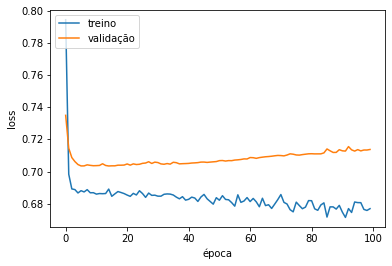

In [ ]:
#Gráfico loss x época do experimento2
grafico_loss_epoca(resultado2)

AUC do experimento 2

In [ ]:
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_valid)
validation_generator = datagen.flow(X_valid, y_valid, batch_size=tam_batch)

In [ ]:
# 
preds = experimento2.predict(validation_generator)

batch_index = 0
data_list = []
while batch_index <= validation_generator.batch_index:
    _, label = validation_generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

gt = np.argmax(data_list, axis=1)
auc = roc_auc_score(gt, preds[:,1])
print("auc :", auc)

auc : 0.5402476780185759


## **Experimento 3** : ResNet152 com imagens do tratamento 1

Usamos agora a ResNet152 com fine-tunning com as imagens do tratamento, camada densa com função de ativação softmax e com a mesma taxa de aprendizado (0.001) e mesmo momentum.

In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
modelo3 = tf.keras.applications.ResNet152(weights='imagenet', include_top=False)

In [ ]:
#Congela camadas pré-treinadas
for layer in modelo3.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
experimento3 = tf.keras.Sequential([
  modelo3,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

experimento3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, None, None, 2048)  58370944  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 4098      
Total params: 58,375,042
Trainable params: 4,098
Non-trainable params: 58,370,944
_________________________________________________________________


In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.5)
experimento3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:

y_train_f = np_utils.to_categorical(y_train_f, 2)
y_valid = np_utils.to_categorical(y_valid, 2)
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_train_f)

In [ ]:
# Número de épocas e o tamanho do batch 
epocas = 100
tam_batch = 32
# Treinamento da rede
resultado6 = experimento3.fit_generator(datagen.flow(X_train_f, y_train_f, batch_size=tam_batch), validation_data=(X_valid, y_valid),steps_per_epoch=len(X_train_f) // tam_batch, epochs=epocas)

Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 0.8068 - accuracy: 0.4843 - val_loss: 0.7287 - val_accuracy: 0.4722
Epoch 2/100
8/8 [==============================] - 7s 916ms/step - loss: 0.7229 - accuracy: 0.5079 - val_loss: 0.6925 - val_accuracy: 0.5278
Epoch 3/100
8/8 [==============================] - 8s 940ms/step - loss: 0.7125 - accuracy: 0.4685 - val_loss: 0.7019 - val_accuracy: 0.5278
Epoch 4/100
8/8 [==============================] - 8s 959ms/step - loss: 0.7125 - accuracy: 0.5354 - val_loss: 0.6957 - val_accuracy: 0.4722
Epoch 5/100
8/8 [==============================] - 8s 949ms/step - loss: 0.7023 - accuracy: 0.4882 - val_loss: 0.6953 - val_accuracy: 0.5278
Epoch 6/100
8/8 [==============================] - 7s 935ms/step - loss: 0.7462 - accuracy: 0.5039 - val_loss: 0.7094 - val_accuracy: 0.4722
Epoch 7/100
8/8 [==============================] - 7s 930ms/step - loss: 0.7109 - accuracy: 0.4961 - val_loss: 0.7242 - val_accuracy: 0.4722
Epoch 8/100
8/8 

### **Avaliação do experimento 3**

Gráfico loss x época do experimento 3

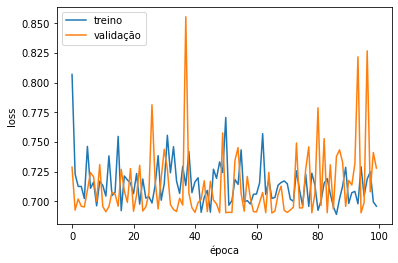

In [ ]:
#Gráfico loss x época do experimento3
grafico_loss_epoca(resultado6)

AUC do experimento 3

In [ ]:
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_valid)
validation_generator = datagen.flow(X_valid, y_valid, batch_size=tam_batch)

In [ ]:
# 
preds = experimento3.predict(validation_generator)

batch_index = 0
data_list = []
while batch_index <= validation_generator.batch_index:
    _, label = validation_generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

gt = np.argmax(data_list, axis=1)
auc = roc_auc_score(gt, preds[:,1])
print("auc :", auc)

auc : 0.43034055727554177


## **Experimento 4: Baseline modificado usando imagens com tratamento e diferente taxa de aprendizado e momentum:**

Usamos o mesmo baseline, mas alteramos a taxa de aprendizagem e momentum

In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)

baseline.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
from keras.utils import np_utils
y_train_f = np_utils.to_categorical(y_train_f, 2)
y_valid = np_utils.to_categorical(y_valid, 2)
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_train_f)

In [ ]:
# Número de épocas e o tamanho do batch 
epocas = 100
tam_batch = 32
# Treinamento da rede
resultado_modificado = baseline.fit_generator(datagen.flow(X_train_f, y_train_f, batch_size=tam_batch), validation_data=(X_valid, y_valid),steps_per_epoch=len(X_train_f) // tam_batch, epochs=epocas)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
8/8 [==============================] - 4s 507ms/step - loss: 1.1886 - accuracy: 0.5117 - val_loss: 0.6919 - val_accuracy: 0.5417
Epoch 2/100
8/8 [==============================] - 4s 461ms/step - loss: 0.8251 - accuracy: 0.4921 - val_loss: 0.8180 - val_accuracy: 0.5278
Epoch 3/100
8/8 [==============================] - 3s 360ms/step - loss: 0.7334 - accuracy: 0.5117 - val_loss: 0.7768 - val_accuracy: 0.4722
Epoch 4/100
8/8 [==============================] - 3s 359ms/step - loss: 0.7513 - accuracy: 0.5197 - val_loss: 0.7027 - val_accuracy: 0.4722
Epoch 5/100
8/8 [==============================] - 3s 362ms/step - loss: 0.7016 - accuracy: 0.5469 - val_loss: 0.7013 - val_accuracy: 0.5278
Epoch 6/100
8/8 [==============================] - 3s 363ms/step - loss: 0.7094 - accuracy: 0.4803 - val_loss: 0.7102 - val_accuracy: 0.4722
Epoch 7/100
8/8 [==============================] - 3s 362ms/step - loss: 0.706

### **Avaliação do experimento 4**

Gráfico loss x época do experimento 4

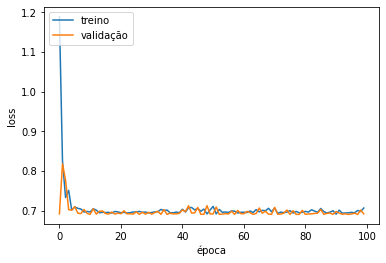

In [ ]:
#Gráfico loss x época do experimento4
grafico_loss_epoca(resultado_modificado)

AUC do experimento 7

In [ ]:
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_valid)
validation_generator = datagen.flow(X_valid, y_valid, batch_size=tam_batch)

In [ ]:
# 
preds = baseline.predict(validation_generator)

batch_index = 0
data_list = []
while batch_index <= validation_generator.batch_index:
    _, label = validation_generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

gt = np.argmax(data_list, axis=1)
auc = roc_auc_score(gt, preds[:,1])
print("auc :", auc)

auc : 0.5224458204334365


## **Experimento 5: Baseline modificado usando imagens com tratamento e mesmas condições do baseline, porém usando aumentação de dados:**

A ideia desse experimento é usar o modelo com o maior AUC obtido porém usando a técnica de aumentação de dados. A justificativa é que usamos todas as imagens de lesões malignas e queremos aumentar a variabilidade para ver seu impacto no mesmo modelo.

In [ ]:
from keras.utils import np_utils

y_train_f = np_utils.to_categorical(y_train_f, 2)
y_valid = np_utils.to_categorical(y_valid, 2)
datagen = ImageDataGenerator(brightness_range=[0.2,1.0], zoom_range=[0.4,1.2], rescale=1./255)
datagen.fit(X_train_f)

In [ ]:
# Número de épocas e o tamanho do batch 
epocas = 500
tam_batch = 32
# Treinamento da rede
resultado = baseline.fit_generator(datagen.flow(X_train_f, y_train_f, batch_size=tam_batch), validation_data=(X_valid, y_valid),steps_per_epoch=len(X_train_f) // tam_batch, epochs=epocas)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
8/8 [==============================] - 11s 1s/step - loss: 0.7252 - accuracy: 0.5315 - val_loss: 0.6980 - val_accuracy: 0.5278
Epoch 2/500
8/8 [==============================] - 10s 1s/step - loss: 0.6937 - accuracy: 0.5315 - val_loss: 0.6931 - val_accuracy: 0.5278
Epoch 3/500
8/8 [==============================] - 10s 1s/step - loss: 0.6995 - accuracy: 0.4646 - val_loss: 0.7173 - val_accuracy: 0.4722
Epoch 4/500
8/8 [==============================] - 10s 1s/step - loss: 0.6946 - accuracy: 0.5236 - val_loss: 0.6928 - val_accuracy: 0.5278
Epoch 5/500
8/8 [==============================] - 10s 1s/step - loss: 0.7020 - accuracy: 0.4882 - val_loss: 0.7273 - val_accuracy: 0.4722
Epoch 6/500
8/8 [==============================] - 10s 1s/step - loss: 0.7065 - accuracy: 0.4567 - val_loss: 0.7125 - val_accuracy: 0.4722
Epoch 7/500
8/8 [==============================] - 10s 1s/step - loss: 0.7000 - accuracy: 

## **Avaliação do experimento 5**

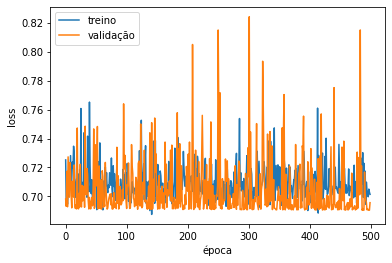

In [ ]:
#Gráfico loss x época do experimento 5
grafico_loss_epoca(resultado)

AUC experimento 5

In [ ]:
datagen = ImageDataGenerator(rotation_range=0)
datagen.fit(X_valid)
validation_generator = datagen.flow(X_valid, y_valid, batch_size=tam_batch)

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

# 
preds = baseline.predict(validation_generator)

batch_index = 0
data_list = []
while batch_index <= validation_generator.batch_index:
    _, label = validation_generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

gt = np.argmax(data_list, axis=1)
auc = roc_auc_score(gt, preds[:,1])
print("auc :", auc)

auc : 0.4713622291021672


Tentamos várias outras estratégias, como visto acima. Usando aumentação de dados, alterando o corte das imagens e testando outros valores para o learning rate e momentum. Nenhuma dessas estratégias performaram melhor que o nosso modelo baseline, o qual obteve uma AUC de 0.63.

Para desenvolvimentos futuros, sugerimos uma mudança na amostragem. Com um aumento na quantidade de dados e posterior balanceamento dos mesmos, podemos obter melhores resultados.